In [1]:
# grid search result not good at all: at chance level.
# try use different thresh tau parameter=selection_number instead of 3.0

In [2]:
%cd /content/drive/MyDrive/
# raw_data is imported from global config

/content/drive/MyDrive


In [3]:
%%capture
! pip install hdf5storage
! pip install mne==0.23.0
! pip install torch
! pip install Braindecode==0.5.1

In [4]:
import sys
import socket
if socket.gethostname() == 'workstation':
    sys.path.extend(['C:/Users/wuxiaolong/Desktop/BCI/googledrive'])
elif socket.gethostname() == 'longsMac':
    sys.path.extend(['/Users/long/Documents/BCI/python_scripts/googleDrive'])
from gesture.config import *

***Copy and Paste your code below.***

In [5]:
import os, re
import matplotlib.pyplot as plt
import hdf5storage
import numpy as np
import torch
import random
from common_dl import set_random_seeds
from common_dl import myDataset
from comm_utils import slide_epochs
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from torch.optim import lr_scheduler
from gesture.models.deepmodel import deepnet,deepnet_resnet
from example.gumbelSelection.ChannelSelection.models import MSFBCNN
from gesture.models.selectionModels import selectionNet

from gesture.myskorch import on_epoch_begin_callback, on_batch_end_callback
from gesture.preprocess.chn_settings import get_channel_setting

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
seed = 20200220  # random seed to make results reproducible
set_random_seeds(seed=seed)

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'

In [6]:

if socket.gethostname() == 'workstation' or socket.gethostname() == 'longsMac':
    if len(sys.argv)>2: # command line
        selection_lr = float(sys.argv[1])
        network_lr = float(sys.argv[2])
else:
    selection_lr = 0.0001
    network_lr = 0.01


In [7]:
import inspect as i
import sys
#sys.stdout.write(i.getsource(deepnet))

In [8]:
sid=10 #4
class_number=5
Session_num,UseChn,EmgChn,TrigChn, activeChan = get_channel_setting(sid)
#fs=[Frequencies[i,1] for i in range(Frequencies.shape[0]) if Frequencies[i,0] == sid][0]
fs=1000

In [9]:
project_dir=data_dir+'preprocessing'+'/P'+str(sid)+'/'
result_dir=project_dir + 'result' + '/'
model_path=project_dir + 'pth' +'/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [10]:
[Frequencies[i,1] for i in range(Frequencies.shape[0]) if Frequencies[i,0] == sid][0]

2000

In [11]:
loadPath = data_dir+'preprocessing'+'/P'+str(sid)+'/preprocessing2.mat'
mat=hdf5storage.loadmat(loadPath)
data = mat['Datacell']
channelNum=int(mat['channelNum'][0,0])
data=np.concatenate((data[0,0],data[0,1]),0)
del mat
# standardization
# no effect. why?
if 1==1:
    chn_data=data[:,-3:]
    data=data[:,:-3]
    scaler = StandardScaler()
    scaler.fit(data)
    data=scaler.transform((data))
    data=np.concatenate((data,chn_data),axis=1)

# stim0 is trigger channel, stim1 is trigger position calculated from EMG signal.
chn_names=np.append(["seeg"]*len(UseChn),["stim0", "emg","stim1"])
chn_types=np.append(["seeg"]*len(UseChn),["stim", "emg","stim"])
info = mne.create_info(ch_names=list(chn_names), ch_types=list(chn_types), sfreq=fs)
raw = mne.io.RawArray(data.transpose(), info)


In [12]:
# gesture/events type: 1,2,3,4,5
events0 = mne.find_events(raw, stim_channel='stim0')
events1 = mne.find_events(raw, stim_channel='stim1')
# events number should start from 0: 0,1,2,3,4, instead of 1,2,3,4,5
events0=events0-[0,0,1]
events1=events1-[0,0,1]

#print(events[:5])  # show the first 5
# Epoch from 4s before(idle) until 4s after(movement) stim1.
raw=raw.pick(["seeg"])
epochs = mne.Epochs(raw, events1, tmin=0, tmax=4,baseline=None)
# or epoch from 0s to 4s which only contain movement data.
# epochs = mne.Epochs(raw, events1, tmin=0, tmax=4,baseline=None)

epoch1=epochs['0'].get_data() # 20 trials. 8001 time points per trial for 8s.
epoch2=epochs['1'].get_data()
epoch3=epochs['2'].get_data()
epoch4=epochs['3'].get_data()
epoch5=epochs['4'].get_data()
list_of_epochs=[epoch1,epoch2,epoch3,epoch4,epoch5]
total_len=list_of_epochs[0].shape[2]

In [13]:
# validate=test=2 trials
trial_number=[list(range(epochi.shape[0])) for epochi in list_of_epochs] #[ [0,1,2,...19],[0,1,2...19],... ]
test_trials=[random.sample(epochi, 2) for epochi in trial_number]
# len(test_trials[0]) # test trials number
trial_number_left=[np.setdiff1d(trial_number[i],test_trials[i]) for i in range(class_number)]

val_trials=[random.sample(list(epochi), 2) for epochi in trial_number_left]
train_trials=[np.setdiff1d(trial_number_left[i],val_trials[i]).tolist() for i in range(class_number)]

# no missing trials
assert [sorted(test_trials[i]+val_trials[i]+train_trials[i]) for i in range(class_number)] == trial_number

test_epochs=[epochi[test_trials[clas],:,:] for clas,epochi in enumerate(list_of_epochs)] # [ epoch0,epoch1,epch2,epoch3,epoch4 ]
val_epochs=[epochi[val_trials[clas],:,:] for clas,epochi in enumerate(list_of_epochs)]
train_epochs=[epochi[train_trials[clas],:,:] for clas,epochi in enumerate(list_of_epochs)]


In [14]:
wind=500
stride=50
X_train=[]
y_train=[]
X_val=[]
y_val=[]
X_test=[]
y_test=[]

In [15]:
for clas, epochi in enumerate(test_epochs):
    Xi,y=slide_epochs(epochi,clas,wind, stride)
    assert Xi.shape[0]==len(y)
    X_test.append(Xi)
    y_test.append(y)
X_test=np.concatenate(X_test,axis=0) # (1300, 63, 500)
y_test=np.asarray(y_test)
y_test=np.reshape(y_test,(-1,1)) # (5, 270)

for clas, epochi in enumerate(val_epochs):
    Xi,y=slide_epochs(epochi,clas,wind, stride)
    assert Xi.shape[0]==len(y)
    X_val.append(Xi)
    y_val.append(y)
X_val=np.concatenate(X_val,axis=0) # (1300, 63, 500)
y_val=np.asarray(y_val)
y_val=np.reshape(y_val,(-1,1)) # (5, 270)

for clas, epochi in enumerate(train_epochs):
    Xi,y=slide_epochs(epochi,clas,wind, stride)
    assert Xi.shape[0]==len(y)
    X_train.append(Xi)
    y_train.append(y)
X_train=np.concatenate(X_train,axis=0) # (1300, 63, 500)
y_train=np.asarray(y_train)
y_train=np.reshape(y_train,(-1,1)) # (5, 270)
chn_num=X_train.shape[1]

In [16]:
train_set=myDataset(X_train,y_train)
val_set=myDataset(X_val,y_val)
test_set=myDataset(X_test,y_test)

batch_size = 32
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, pin_memory=False)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True, pin_memory=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, pin_memory=False)

train_size=len(train_loader.dataset)
val_size=len(val_loader.dataset)
test_size=len(test_loader.dataset)

In [17]:
# These values we found good for shallow network:
#lr = 0.0001
weight_decay = 1e-10
batch_size = 32
n_epochs = 200

In [18]:
#one_window.shape : (208, 500)

In [19]:
# Extract number of chans and time steps from dataset
one_window=next(iter(train_set))[0]
n_chans = one_window.shape[0]

img_size=[n_chans,wind]
#net = timm.create_model('visformer_tiny',num_classes=n_classes,in_chans=1,img_size=img_size)
#net = deepnet(n_chans,class_number,input_window_samples=wind,final_conv_length='auto',) # 81%
selection_number=10
net = selectionNet(n_chans,class_number,wind,selection_number) # 81%
#net=MSFBCNN([n_chans,wind],class_number)

if cuda:
    net.cuda()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [20]:
if isinstance(net, selectionNet):
    optimizer = torch.optim.Adadelta(
    [
        {"params": net.selection_layer.parameters(), "lr": selection_lr},
        {"params": net.network.parameters(),"lr":network_lr},
    ],
    lr=0.0,
    )
else:
    optimizer = torch.optim.Adam(net.parameters(), lr=network_lr)

optimizer = torch.optim.Adam(net.parameters(), lr=network_lr)


In [21]:
#lr = 0.002
#weight_decay = 1e-10
weight_decay = 5e-4
epoch_num = 200
criterion = torch.nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
#optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
#optimizer = torch.optim.Adadelta(net.parameters(), lr=lr)
#optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# Decay LR by a factor of 0.1 every 7 epochs
lr_schedulerr = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [22]:
def exponential_decay_schedule(start_value,end_value,epochs,end_epoch):
    t = torch.FloatTensor(torch.arange(0.0,epochs))
    p = torch.clamp(t/end_epoch,0,1)
    out = start_value*torch.pow(end_value/start_value,p)

    return out
start_temp=10
end_temp=0.1
temperature_schedule = exponential_decay_schedule(start_temp,end_temp,epoch_num,int(epoch_num*3/4))
thresh_schedule = exponential_decay_schedule(5,1.1,epoch_num,epoch_num) #
#lamba=400.0 

In [23]:
import inspect as i
import sys
#sys.stdout.write(i.getsource(selectionNet))

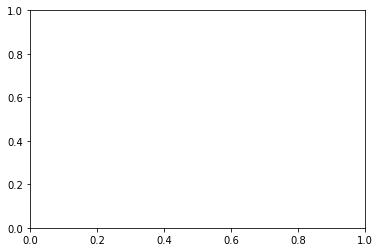

In [24]:
if isinstance(net, selectionNet):
    fig, ax=plt.subplots()

In [25]:
lamba=1.0 # penalty of selecting the same channel.

In [26]:
if isinstance(net, selectionNet):
    net.set_freeze(False)

H=[]
S=[]
Z=[]

epoch_score=[]
for epoch in range(epoch_num):
    epoch_score.append([])
    H.append([])
    S.append([])
    Z.append([])
    print("------ epoch " + str(epoch) + " -----")
    
    if isinstance(net, selectionNet):
        net.set_thresh(thresh_schedule[epoch])
        net.set_temperature(temperature_schedule[epoch])
    net.train()

    loss_epoch = 0

    running_loss = 0.0
    running_corrects = 0
    for batch, (trainx, trainy) in enumerate(train_loader):
        optimizer.zero_grad()
        if (cuda):
            trainx = trainx.float().cuda()
        else:
            trainx = trainx.float()
        y_pred = net(trainx)
        #print("y_pred shape: " + str(y_pred.shape))
        preds = y_pred.argmax(dim=1, keepdim=True)
        #_, preds = torch.max(y_pred, 1)

        if cuda:
            loss = criterion(y_pred, trainy.squeeze().cuda().long())
        else:
            loss = criterion(y_pred, trainy.squeeze())
        if isinstance(net, selectionNet):
            reg = net.regularizer(lamba,weight_decay)
            print("---------")
            #print(reg)
            #print(loss)
            loss=loss+reg
            #print(loss)
        loss.backward()  # calculate the gradient and store in .grad attribute.
        optimizer.step()
        running_loss += loss.item() * trainx.shape[0]
        running_corrects += torch.sum(preds.cpu().squeeze() == trainy.squeeze())
    #print("train_size: " + str(train_size))
    lr_schedulerr.step() # test it
    epoch_loss = running_loss / train_size
    train_acc = running_corrects.double() / train_size
    epoch_score[epoch].append(train_acc)
    print("Training loss: {:.2f}; Accuracy: {:.2f}.".format(epoch_loss,train_acc.item()))
    #print("Training " + str(epoch) + ": loss: " + str(epoch_loss) + "," + "Accuracy: " + str(epoch_acc.item()) + ".")

    state = {
            'net': net.state_dict(),
            'optimizer': optimizer.state_dict(),
             'epoch': epoch,
             'loss': epoch_loss
        }
    savepath = model_path + 'checkpoint' + str(epoch) + '.pth'
    #torch.save(state, savepath)

    if isinstance(net, selectionNet):
        hi, sel, probas = net.monitor()
        H[epoch].append(hi.detach().cpu().numpy())
        S[epoch].append(sel.detach().cpu().numpy())
        Z[epoch].append(probas.detach().cpu().numpy())
        #ax.plot(probas.detach().cpu().numpy())
        #fig.savefig(result_dir + 'prob_dist' + str(epoch) + '.png')
        ax.clear()


    running_loss = 0.0
    running_corrects = 0
    if epoch % 1 == 0:
        with torch.no_grad():
            net.eval()
            # print("Validating...")
            with torch.no_grad():
                for _, (val_x, val_y) in enumerate(val_loader):
                    if (cuda):
                        val_x = val_x.float().cuda()
                        # val_y = val_y.float().cuda()
                    else:
                        val_x = val_x.float()
                        # val_y = val_y.float()
                    outputs = net(val_x)
                    #_, preds = torch.max(outputs, 1)
                    preds = outputs.argmax(dim=1, keepdim=True)

                    running_corrects += torch.sum(preds.cpu().squeeze() == val_y.squeeze())

            val_acc = running_corrects.double() / val_size
            print("Evaluation accuracy: {:.2f}.".format(val_acc.item()))
    epoch_score[epoch].append(val_acc)

Streaming output truncated to the last 5000 lines.
---------
tensor(1.4715, device='cuda:0', grad_fn=<UnbindBackward>)
---------
tensor(1.4715, device='cuda:0', grad_fn=<UnbindBackward>)
---------
tensor(1.4715, device='cuda:0', grad_fn=<UnbindBackward>)
---------
tensor(1.4715, device='cuda:0', grad_fn=<UnbindBackward>)
---------
tensor(1.4715, device='cuda:0', grad_fn=<UnbindBackward>)
---------
tensor(1.4715, device='cuda:0', grad_fn=<UnbindBackward>)
---------
tensor(1.4715, device='cuda:0', grad_fn=<UnbindBackward>)
---------
tensor(1.4715, device='cuda:0', grad_fn=<UnbindBackward>)
---------
tensor(1.4715, device='cuda:0', grad_fn=<UnbindBackward>)
---------
tensor(1.4715, device='cuda:0', grad_fn=<UnbindBackward>)
---------
tensor(1.4715, device='cuda:0', grad_fn=<UnbindBackward>)
---------
tensor(1.4715, device='cuda:0', grad_fn=<UnbindBackward>)
---------
tensor(1.4715, device='cuda:0', grad_fn=<UnbindBackward>)
---------
tensor(1.4715, device='cuda:0', grad_fn=<UnbindBackward

In [27]:
# start to penalize at epoch =63

In [28]:
epoch_score=np.asarray(epoch_score)
filename = result_dir + 'epoch_scores'
np.save(filename,epoch_score)
HH=np.asarray(H)
filename = result_dir + 'HH'
np.save(filename,HH)
SS=np.asarray(S) # selection 
filename = result_dir + 'SS'
np.save(filename,SS)
ZZ=np.asarray(Z) # probability
filename = result_dir + 'ZZ'
np.save(filename,ZZ)

In [30]:
H[0]

[array([0.9977051 , 0.9989928 , 0.99841875, 0.9982169 , 0.99841577,
        0.9981745 , 0.99818724, 0.9984817 , 0.9986212 , 0.9992387 ],
       dtype=float32)]

In [31]:
HH=np.asarray(H)

In [32]:
plt.rcParams['figure.figsize'] = [50, 150]

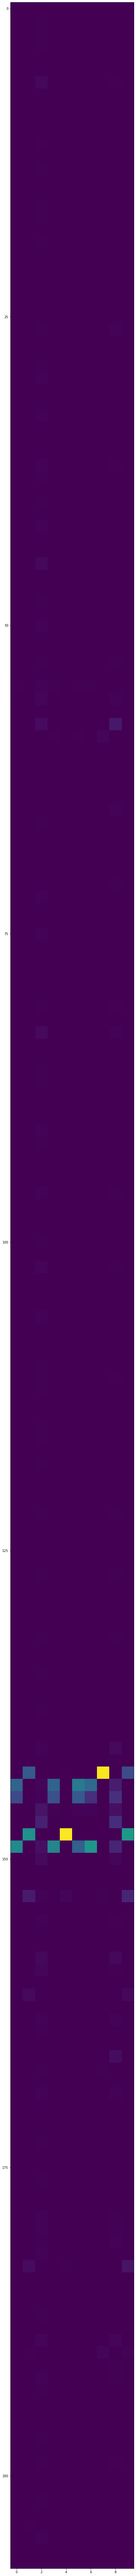

In [35]:
plt.imshow(ZZ[10][0])

In [34]:
net

selectionNet(
  (selection_layer): SelectionLayer()
  (network): deepnet(
    (Add_dim): expand_dim()
    (dimshuffle): Expression(expression=swap_time_spat) 
    (conv_time): Conv2d(1, 64, kernel_size=(50, 1), stride=(1, 1))
    (conv_spat): Conv2d(64, 64, kernel_size=(1, 10), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin): Expression(expression=elu) 
    (pool): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
    (drop_2): Dropout(p=0.5, inplace=False)
    (conv_2): Conv2d(64, 50, kernel_size=(10, 1), stride=(1, 1), bias=False)
    (bnorm_2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin_2): Expression(expression=elu) 
    (drop_3): Dropout(p=0.5, inplace=False)
    (conv_3): Conv2d(50, 50, kernel_size=(10, 1), stride=(1, 1), bias=False)
    (bnorm_3): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_r